In [1]:
import torch
import torchvision
from torchvision import models, transforms
from matplotlib import pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from PIL import Image

>>>>>>>>>>>INTERACT HERE

>>>>>>>>>>>>>>>>>>RUN ALL

In [2]:
data_transforms = {
    'test': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
def visualize(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        #ax = plt.subplot(2,2,1)
        #ax.axis('off')
        #ax.set_title(f'Predicted: {class_names[preds[0]]}')
        #imshow(img.cpu().data[0])
    return class_names[preds[0]]

In [5]:
def visualize_wimg(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
    return class_names[preds[0]]

In [6]:
def confusion_matrix(model, folder_path):
    catagories = os.listdir(folder_path)
    if '.DS_Store' in catagories:
        catagories.remove('.DS_Store')
    num_catagories = len(catagories)
    #import confusion matrix
    value_library = {}
    confusion_matrix = np.zeros((num_catagories, num_catagories))
    catagory_list = os.listdir(folder_path)
    if '.DS_Store' in catagory_list:
        catagory_list.remove('.DS_Store')
    for catagory in catagory_list:
        catagory_path = os.path.join(folder_path, catagory)
        img_list = os.listdir(catagory_path)
        if '.DS_Store' in img_list:
            img_list.remove('.DS_Store')
        
        #shuffle order of img_list
        np.random.shuffle(img_list)
        for img in img_list:
            img_path = os.path.join(catagory_path, img)
            predicted = visualize(model, img_path)
            predicted_index = catagory_list.index(predicted)
            actual_index = catagory_list.index(catagory)
            if predicted_index != actual_index:
                visualize_wimg(model,img_path)
                print('actual identity:' , catagory)
            confusion_matrix[actual_index][predicted_index] += 1
           
    for catagory in catagory_list:
        catagory_index = catagory_list.index(catagory)
        true_positive = confusion_matrix[catagory_index][catagory_index]
        false_negative = confusion_matrix[catagory_index][:].sum() - true_positive
        num = 0
        for row in confusion_matrix:
            num = num + row[catagory_index]
        false_positive = num - true_positive
        
        true_negative = confusion_matrix[:][:].sum() - confusion_matrix[catagory_index][:].sum() - confusion_matrix[:][catagory_index].sum() + confusion_matrix[catagory_index][catagory_index]
        values = {}
        values['true_positive'] = true_positive
        values['true_negative'] = true_negative
        values['false_positive'] = false_positive
        values['false_negative'] = false_negative
        value_library[catagory] = values
        
    return value_library



In [7]:
def confusion_matrix_2cat(model, folder_path):
    num_catagories = len(os.listdir(folder_path))
    value_library = {}
    confusion_matrix = np.zeros((num_catagories, num_catagories))
    catagory_list = os.listdir(folder_path)
    for catagory in catagory_list:
        catagory_path = os.path.join(folder_path, catagory)
        img_list = os.listdir(catagory_path)
        for img in img_list:
            img_path = os.path.join(catagory_path, img)
            predicted = visualize(model, img_path)
            predicted_index = catagory_list.index(predicted)
            actual_index = catagory_list.index(catagory)
            
            confusion_matrix[actual_index][predicted_index] += 1
            #write functions to calculate true positive, true negative, false positive, false negative
    for catagory in catagory_list:
        catagory_index = catagory_list.index(catagory)
        true_positive = confusion_matrix[catagory_index][catagory_index]
        if catagory_index == 0:
            false_negative = confusion_matrix[catagory_index][catagory_index+1]
        if catagory_index == 1:
            false_negative = confusion_matrix[catagory_index][catagory_index-1]
        false_positive = confusion_matrix[:][catagory_index].sum() - true_positive
        true_negative = confusion_matrix[:][:].sum() - confusion_matrix[catagory_index][:].sum() - confusion_matrix[:][catagory_index].sum() + confusion_matrix[catagory_index][catagory_index]
        values = {}
        values['true_positive'] = true_positive
        values['true_negative'] = true_negative
        values['false_positive'] = false_positive
        values['false_negative'] = false_negative
        value_library[catagory] = values
    return value_library
 

In [8]:
def evaluation_metrics(value_library):
    evaluation_metrics = {}
    for catagory in value_library:
        values = value_library[catagory]
        true_positive = values['true_positive']
        true_negative = values['true_negative']
        false_positive = values['false_positive']
        false_negative = values['false_negative']
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1_score = 2 * ((precision * recall) / (precision + recall))
        evaluation_metrics[catagory] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}
    return evaluation_metrics


In [9]:
def average_evaluation_metrics(evaluation_metrics):
    average_evaluation_metrics = {}
    accuracy = 0
    precision = 0
    recall = 0
    f1_score = 0
    for catagory in evaluation_metrics:
        values = evaluation_metrics[catagory]
        accuracy += values['accuracy']
        precision += values['precision']
        recall += values['recall']
        f1_score += values['f1_score']
    average_evaluation_metrics['accuracy'] = accuracy / len(evaluation_metrics)
    average_evaluation_metrics['precision'] = precision / len(evaluation_metrics)
    average_evaluation_metrics['recall'] = recall / len(evaluation_metrics)
    average_evaluation_metrics['f1_score'] = f1_score / len(evaluation_metrics)
    return average_evaluation_metrics


In [10]:
def visualize_eval(value_library, evaluation_metric_lib, average_evaluation_metrics_lib):
    print('\n' +'\n' +'~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for value in value_library:
        print(value + ':')
        print(value_library[value])
        print('catagory metrics: ')
        print(evaluation_metric_lib[value])
        print ('\n')
    print('########################################')
    print('average evaluation metrics: ')
    for val in average_evaluation_metrics_lib:
        print(val + ': ' + str(average_evaluation_metrics_lib[val]))
    print('########################################')

In [11]:
def evaluate(model, folder_path, cat_num):
    if cat_num == 2:
        value_library = confusion_matrix_2cat(model, folder_path)
    else:
        value_library = confusion_matrix(model, folder_path)
    evaluation_metric_lib = evaluation_metrics(value_library)
    average_evaluation_metrics_lib = average_evaluation_metrics(evaluation_metric_lib)
    visualize_eval(value_library, evaluation_metric_lib, average_evaluation_metrics_lib)
    return average_evaluation_metrics_lib

runtime test

In [8]:
path_to_model = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.3_model.pt'
img_path = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial run/inpaint.jpg'

class_names = ['laying', 'sitting', 'standing', 'unkonwn']

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(path_to_model)

In [10]:
visualize(model, img_path)

'laying'

>>>>>>>>>>>>>INTERACT HERE

Trial 3.0
inpainted set

In [17]:
path_to_model = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.0.pt'
path_to_folder = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/inpainted/test'

In [18]:
class_names = os.listdir(path_to_folder)
class_names.sort()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(path_to_model)
print(class_names)
class_names.remove('.DS_Store')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/inpainted/test'

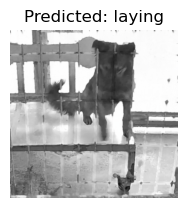

actual identity: sitting


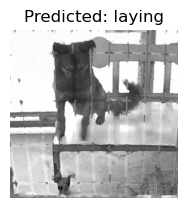

actual identity: sitting


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 17.0, 'true_negative': 26.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


sitting:
{'true_positive': 13.0, 'true_negative': 26.0, 'false_positive': 0.0, 'false_negative': 2.0}
catagory metrics: 
{'accuracy': 0.9512195121951219, 'precision': 1.0, 'recall': 0.8666666666666667, 'f1_score': 0.9285714285714286}


laying:
{'true_positive': 11.0, 'true_negative': 32.0, 'false_positive': 2.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 0.9555555555555556, 'precision': 0.8461538461538461, 'recall': 1.0, 'f1_score': 0.9166666666666666}


########################################
average evaluation metrics: 
accuracy: 0.9689250225835592
precision: 0.9487179487179488
recall: 0.9555555555555556
f1_score: 0.9484126984126985
########################################


{'accuracy': 0.9689250225835592,
 'precision': 0.9487179487179488,
 'recall': 0.9555555555555556,
 'f1_score': 0.9484126984126985}

In [43]:
evaluate(model, path_to_folder, 3)


>>>>>>NEW MODEL SET

trial 3.1
4 catagory inpainted set


In [44]:
model = torch.jit.load('/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.1_model.pt')
class_names = ['laying','sitting','standing','unknown']
path_to_folder = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/train_4cat/test'

In [45]:
evaluate(model, path_to_folder,3)



~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 17.0, 'true_negative': 26.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


sitting:
{'true_positive': 9.0, 'true_negative': 34.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


unknown:
{'true_positive': 6.0, 'true_negative': 37.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


laying:
{'true_positive': 11.0, 'true_negative': 32.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


########################################
average evaluation metrics: 
accuracy: 1.0
precision: 1.0
recall: 1.0
f1_score: 1.0
########################################


{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}

model 3.2- same folder (4cat inpainted)

In [12]:
path_to_model = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.2_model.pt'
model = torch.jit.load(path_to_model)


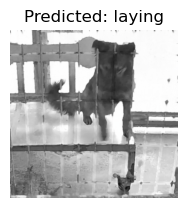

actual identity: sitting


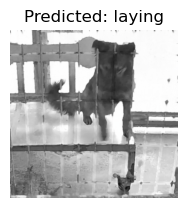

actual identity: sitting


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 17.0, 'true_negative': 26.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


sitting:
{'true_positive': 7.0, 'true_negative': 32.0, 'false_positive': 0.0, 'false_negative': 2.0}
catagory metrics: 
{'accuracy': 0.9512195121951219, 'precision': 1.0, 'recall': 0.7777777777777778, 'f1_score': 0.8750000000000001}


unknown:
{'true_positive': 6.0, 'true_negative': 37.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


laying:
{'true_positive': 11.0, 'true_negative': 32.0, 'false_positive': 2.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 0.9555555555555556, 'precision': 0.8461538461538461, 'recall': 1.0, 'f1_score': 0.9166666666666666}


########################################
average evaluatio

{'accuracy': 0.9766937669376694,
 'precision': 0.9615384615384616,
 'recall': 0.9444444444444444,
 'f1_score': 0.9479166666666666}

In [47]:
evaluate(model, path_to_folder,4)

model 3.3

In [20]:
path_to_folder = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/datasets/train_4cat/test'
path_to_model = '/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.3_model.pt'

class_names = os.listdir(path_to_folder)
class_names.sort()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(path_to_model)
if '.DS_Store' in class_names:
    class_names.remove('.DS_Store')
print(class_names)

['laying', 'sitting', 'standing', 'unknown']


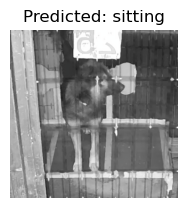

actual identity: standing


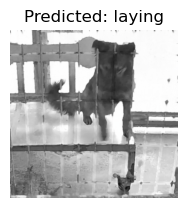

actual identity: sitting


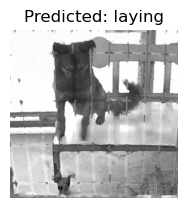

actual identity: sitting


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 16.0, 'true_negative': 25.0, 'false_positive': 0.0, 'false_negative': 1.0}
catagory metrics: 
{'accuracy': 0.9761904761904762, 'precision': 1.0, 'recall': 0.9411764705882353, 'f1_score': 0.9696969696969697}


sitting:
{'true_positive': 7.0, 'true_negative': 32.0, 'false_positive': 1.0, 'false_negative': 2.0}
catagory metrics: 
{'accuracy': 0.9285714285714286, 'precision': 0.875, 'recall': 0.7777777777777778, 'f1_score': 0.823529411764706}


unknown:
{'true_positive': 6.0, 'true_negative': 37.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


laying:
{'true_positive': 11.0, 'true_negative': 32.0, 'false_positive': 2.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 0.9555555555555556, 'precision': 0.8461538461538461, 'recall': 1.0, 'f1_score': 0.9166666666666666}


############

{'accuracy': 0.9650793650793651,
 'precision': 0.9302884615384616,
 'recall': 0.9297385620915033,
 'f1_score': 0.9274732620320856}

In [21]:
model = torch.jit.load(path_to_model)
evaluate(model, path_to_folder,4)


MODEL 3.4

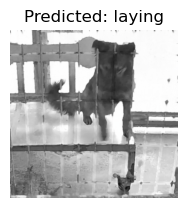

actual identity: sitting


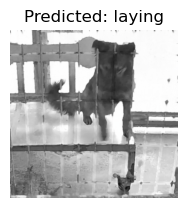

actual identity: sitting


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 17.0, 'true_negative': 26.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


sitting:
{'true_positive': 7.0, 'true_negative': 32.0, 'false_positive': 0.0, 'false_negative': 2.0}
catagory metrics: 
{'accuracy': 0.9512195121951219, 'precision': 1.0, 'recall': 0.7777777777777778, 'f1_score': 0.8750000000000001}


unknown:
{'true_positive': 6.0, 'true_negative': 37.0, 'false_positive': 0.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


laying:
{'true_positive': 11.0, 'true_negative': 32.0, 'false_positive': 2.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 0.9555555555555556, 'precision': 0.8461538461538461, 'recall': 1.0, 'f1_score': 0.9166666666666666}


########################################
average evaluatio

{'accuracy': 0.9766937669376694,
 'precision': 0.9615384615384616,
 'recall': 0.9444444444444444,
 'f1_score': 0.9479166666666666}

In [49]:
model = torch.jit.load('/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.4_model.pt')
evaluate(model, path_to_folder,4)

3.5IPx

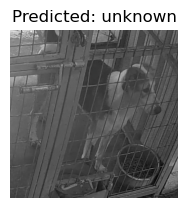

actual identity: standing


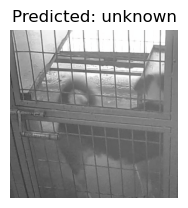

actual identity: standing


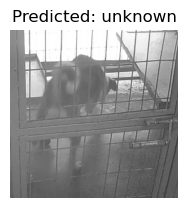

actual identity: standing


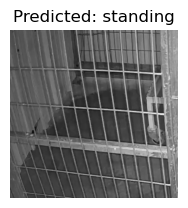

actual identity: unknown


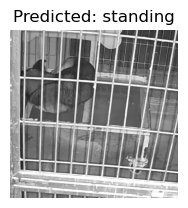

actual identity: laying


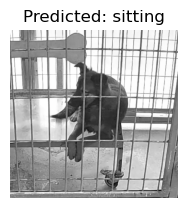

actual identity: laying


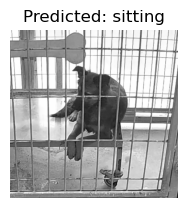

actual identity: laying


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 13.0, 'true_negative': 48.0, 'false_positive': 2.0, 'false_negative': 3.0}
catagory metrics: 
{'accuracy': 0.9242424242424242, 'precision': 0.8666666666666667, 'recall': 0.8125, 'f1_score': 0.8387096774193549}


sitting:
{'true_positive': 13.0, 'true_negative': 54.0, 'false_positive': 2.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 0.9710144927536232, 'precision': 0.8666666666666667, 'recall': 1.0, 'f1_score': 0.9285714285714286}


unknown:
{'true_positive': 16.0, 'true_negative': 49.0, 'false_positive': 3.0, 'false_negative': 1.0}
catagory metrics: 
{'accuracy': 0.9420289855072463, 'precision': 0.8421052631578947, 'recall': 0.9411764705882353, 'f1_score': 0.8888888888888888}


laying:
{'true_positive': 18.0, 'true_negative': 43.0, 'false_positive': 0.0, 'false_negative': 3.0}
catagory metrics: 
{'accuracy': 0.953125, 'precision': 1.0, 'recall': 0.85714285714

{'accuracy': 0.9476027256258235,
 'precision': 0.893859649122807,
 'recall': 0.9027048319327732,
 'f1_score': 0.8948117294891488}

In [16]:
path_to_folder = ('/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/datasets/IPx_data/test')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = ['laying','sitting','standing','unknown']
model = torch.jit.load('/Users/david/Desktop/shelter_dogs_research/Trials/trial3_pup1_env12/trial3_docs/trial3.5IPx.pt')
evaluate(model, path_to_folder,3)